# Loading Modules

In [162]:
from display import Display, minmax, place_object
from main import init
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST
from spatial_transformer import SpatialTransformer
from where import RetinaFill, WhereShift, RetinaBackground, RetinaMask

# Loading the Data

- Loading the data with the parameters given in the .json file for the What/Where model

In [163]:
args = init(filename='../data/2020-07-01')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

# Exploring the MNIST with the what noise parameters

- 28x28 pixel with shift and noise

In [205]:
transform=transforms.Compose([
                               WhatShift(args,i_offset=None, j_offset=None),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [206]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [207]:
data, label = next(iter(train_loader))

In [208]:
data.shape

torch.Size([100, 1, 28, 28])

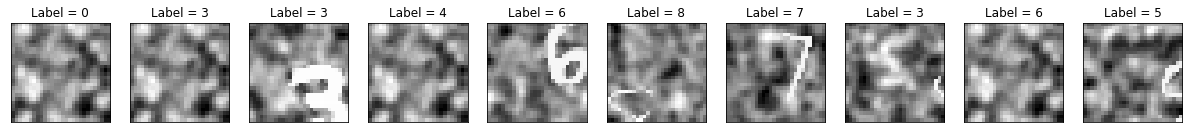

In [209]:
N_plot = 10
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
    ax.set_title("Label = %d"%(label[i_ax].item()))
    ax.set_xticks([])
    ax.set_yticks([])

# Exploring the MNIST with where noise parameters

- 128x128 pixet with shift, noise and circular mask

In [192]:
transform_big = transforms.Compose([
    RetinaFill(N_pic=args.N_pic),
    WhereShift(args),
    RetinaBackground(contrast=args.contrast,
                     noise=args.noise,
                     sf_0=args.sf_0,
                     B_sf=args.B_sf),
    RetinaMask(N_pic=args.N_pic),
    transforms.ToTensor()
    #FullfieldRetinaWhiten(N_pic=args.N_pic),
    #FullfieldRetinaTransform(Retina(args).retina_transform_vector),
    #FullfieldToFloatTensor(),
    # Normalize(fullfield=True)
    # transforms.Normalize((args.mean,), (args.std,))
])

In [193]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform_big,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform_big,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [194]:
data_big, label_big = next(iter(train_loader))

In [195]:
data_big.shape

torch.Size([100, 1, 128, 128])

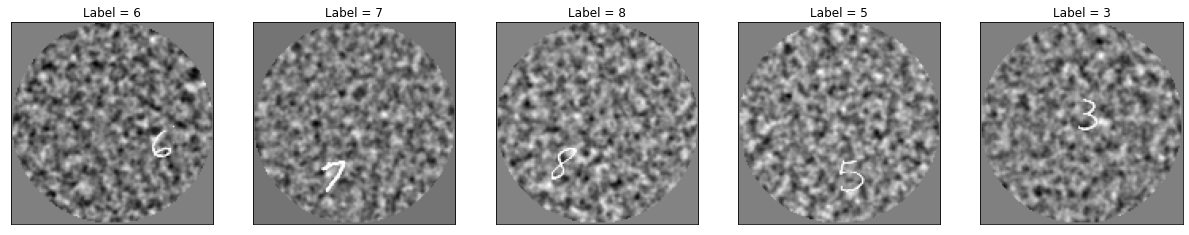

In [197]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data_big[i_ax, 0, :, :], cmap=plt.gray())
    ax.set_title("Label = %d"%(label_big[i_ax].item()))
    ax.set_xticks([])
    ax.set_yticks([])

# Spatial Transformer Network

In [210]:
def check_cuda() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [211]:
device = check_cuda()
device

device(type='cuda')

In [212]:
model = SpatialTransformer().to(device)

In [213]:
model

SpatialTransformer(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [214]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, dtype=torch.float), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device, dtype=torch.float), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321665
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.305728

Test set: Average loss: 2.3016, Accuracy: 1135/10000 (11%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.294143
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.312218

Test set: Average loss: 2.3013, Accuracy: 1135/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.307837
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.310163

Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.295372
Train Epoch: 4 [50000/60000 (83%)]	Loss: 2.299019

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.293153
Train Epoch: 5 [50000/60000 (83%)]	Loss: 2.308825

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.301166
Train Epoch: 6 [50000/60000 (83%)]	Loss: 2.310244

Test set: Average loss: 2.3009, Accuracy: 1135/10000 (11%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.301060
Train Epoch: 7 [500

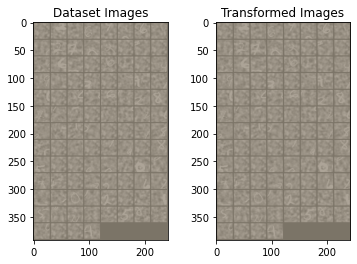

In [215]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

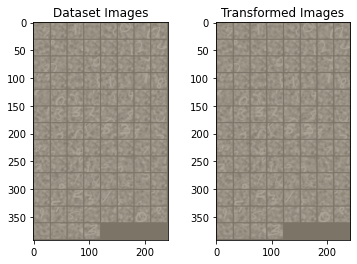

In [216]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
        
# Visualize the STN transformation on some input batch
visualize_stn()